<a href="https://colab.research.google.com/github/rks16/Python-new-/blob/main/DTTE_Tutorial_28_Applying_Bayes_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 3 - Applying Bayes Classifiers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1TuDbIyso6irdyBFgaHRpC-PxUICWPHcS?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/tree/main/Bayesian/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

In [2]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [3]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2023-10-13 06:02:37--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json’

arxiv-paper-data.js 100%[===================>]  69.07M  --.-KB/s    in 0.1s    

2023-10-13 06:02:37 (480 MB/s) - ‘arxiv-paper-data.json’ saved [72422946/72422946]



Let's make a few assumptions to come up with our first general model for classification:
* The different features contribute equally to the result
* The features are independent

## Bayes Classifiers in Scikit Learn

### Simple 1-D Classfication using Naive Bayes in Continuous Space

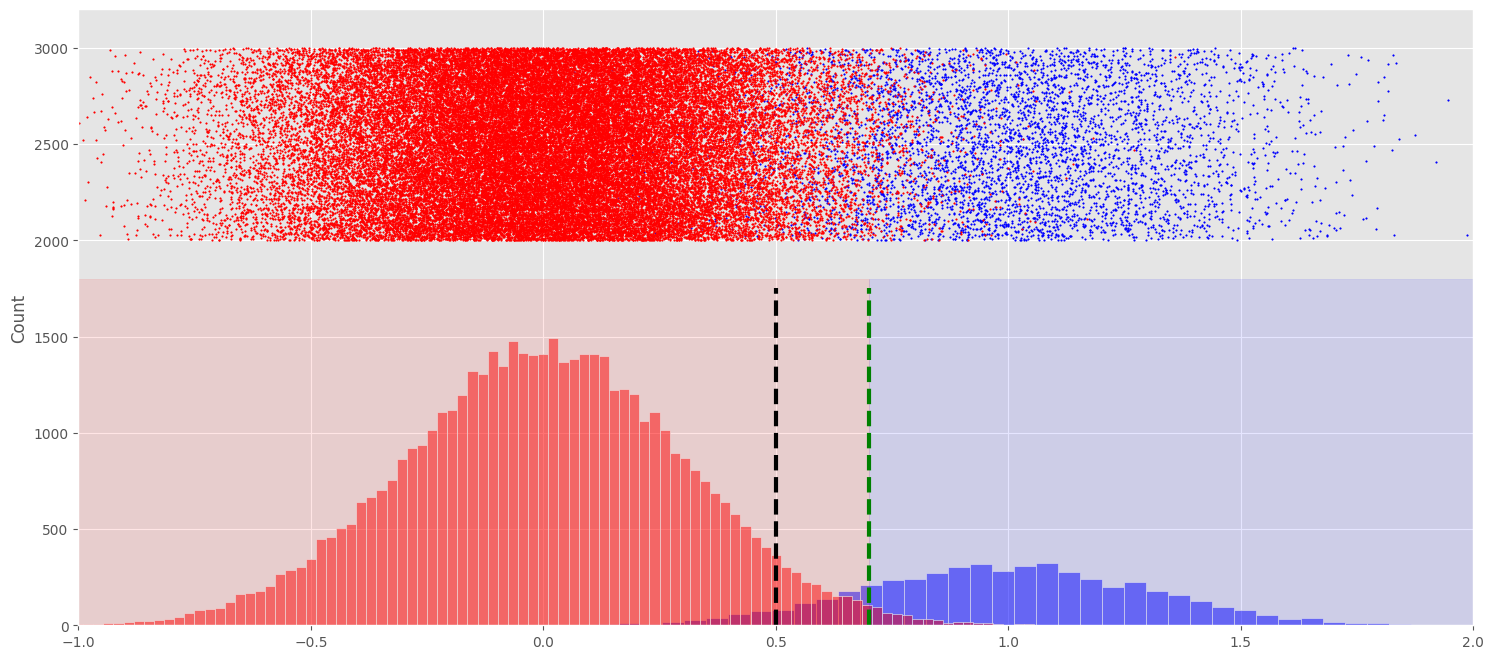

In [4]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [5]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


## Gaussian Bayes Predictor on Predicting Flowers

### Predictors in Scikit Learn

In [6]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

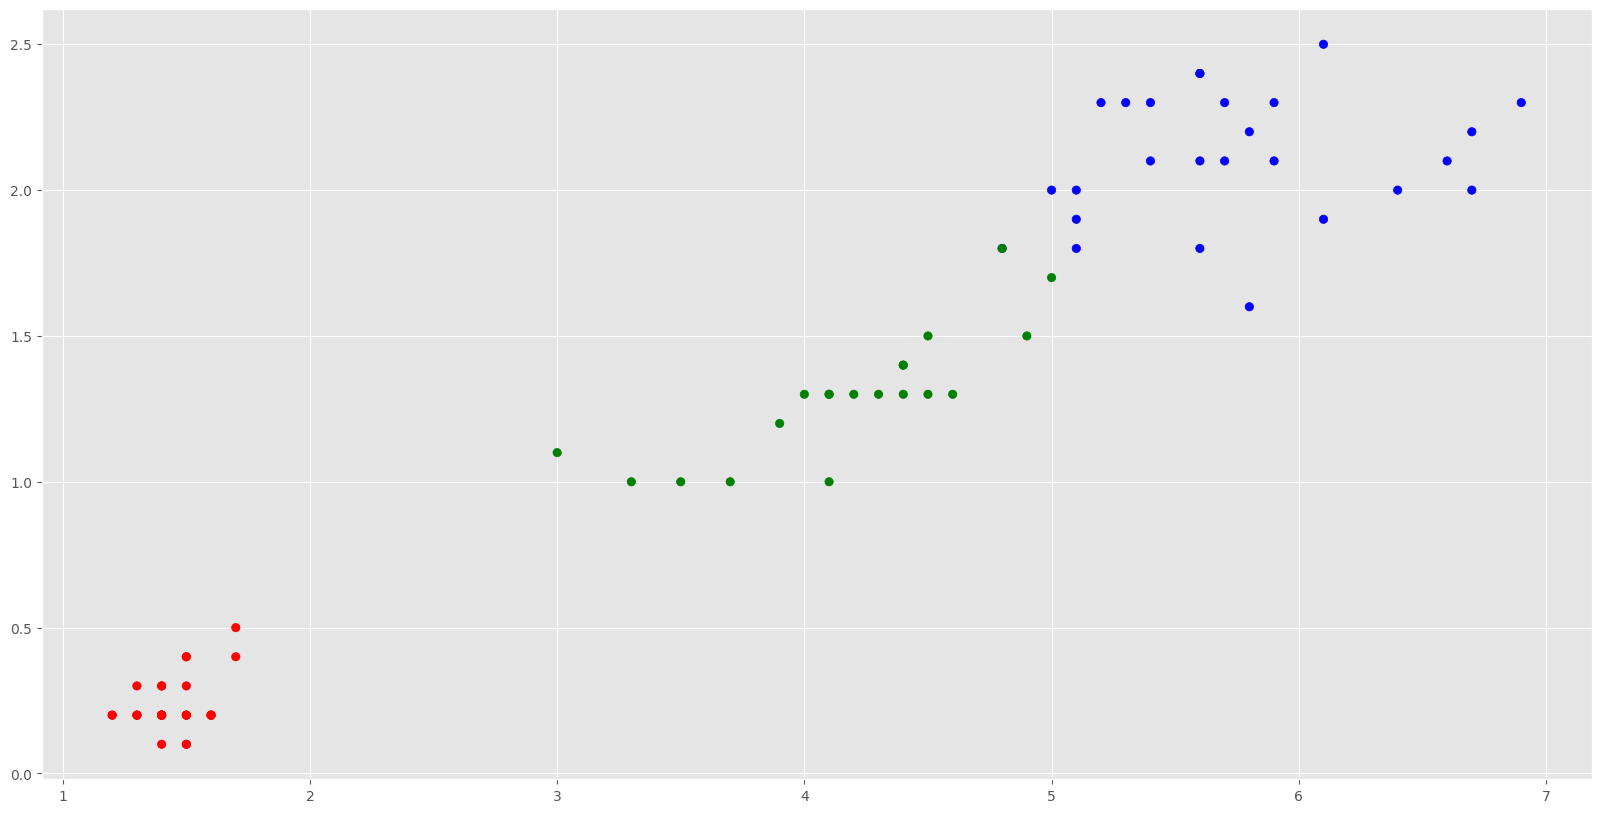

In [7]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

### Visualizing the Decision Surface

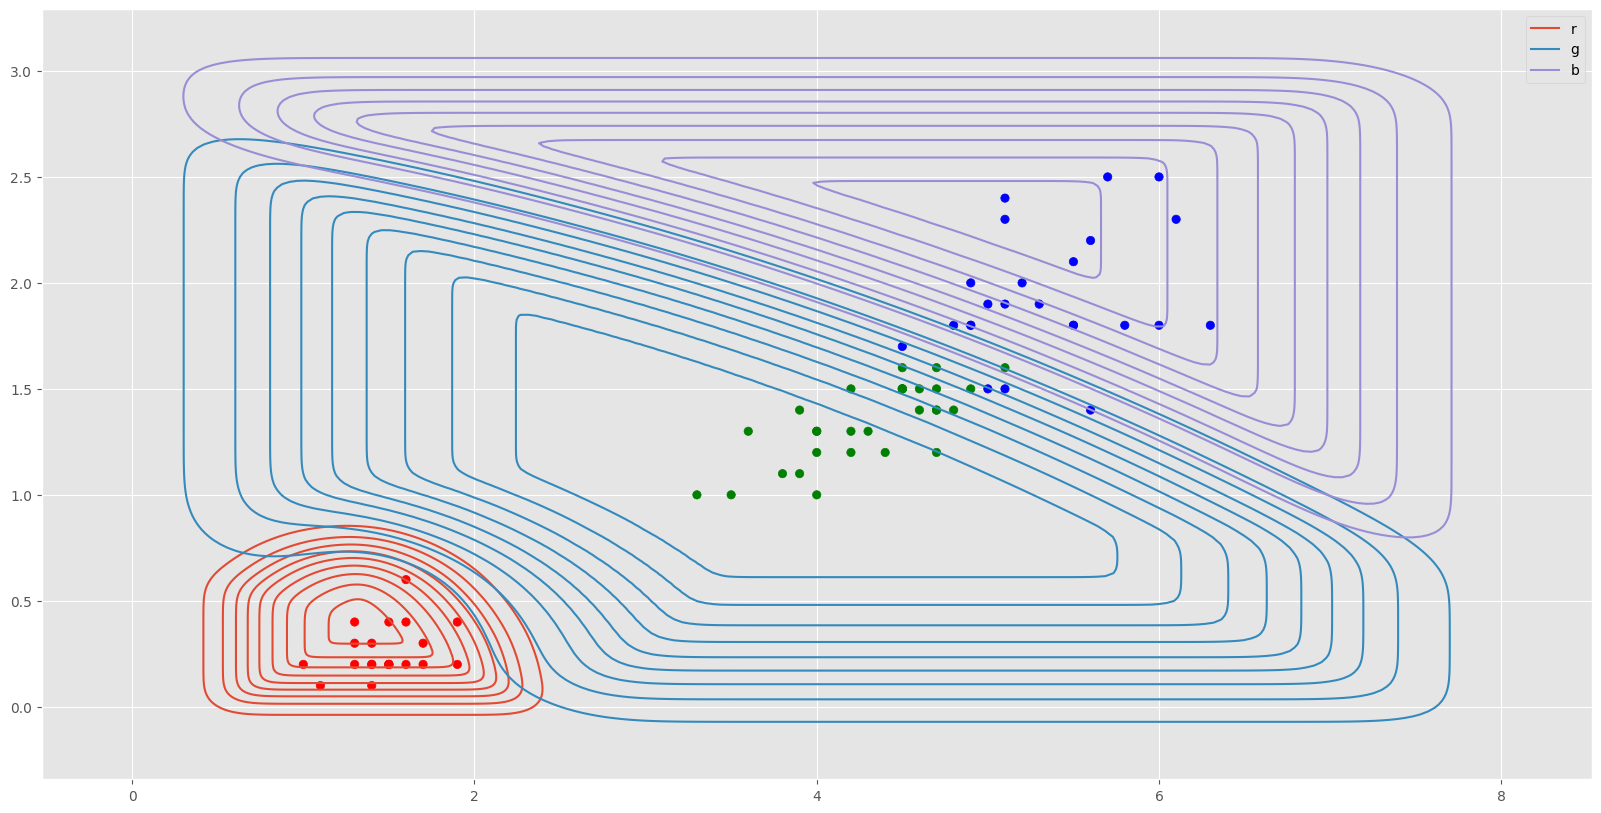

In [8]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

## Bayes on Text - Classifying papers at Arxiv

### Data Cleaning and Preprocessing

In [9]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [10]:
SAMPLES_COMP = 3500 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 2500 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 1  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 8  #@param {type: "slider", min: 4, max: 20}

In [11]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False),
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split()
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

train_df

,id,summary,tag,title,year,keywords
17058,1708.02561v1,We explore context representation learning met...,cs,Neural-based Context Representation Learning f...,2017,"[representation, classification, extensively, ..."
14905,1207.1420v1,This paper addresses the problem of mapping na...,cs,Learning to Map Sentences to Logical Form: Str...,2012,"[addresses, sentences, encodings, algorithm, s..."
8429,1606.05328v2,This work explores conditional image generatio...,cs,Conditional Image Generation with PixelCNN Dec...,2016,"[conditional, generation, architecture, condit..."
31340,1803.00425v1,Graph-based methods are known to be successful...,cs,Graph Kernels based on High Order Graphlet Par...,2018,"[successful, classification, structured, corre..."
40267,1803.00395v1,Fourier ptychographi cmicroscopy(FPM) is a new...,cs,Fast and robust misalignment correction of Fou...,2018,"[ptychographi, developed, computational, techn..."
...,...,...,...,...,...,...
18589,1106.0285v1,"This paper presents GRT, a domain-independent ...",cs,The GRT Planning System: Backward Heuristic Co...,2011,"[independent, heuristic, processing, estimates..."
11520,1605.05775v2,Tensor networks are efficient representations ...,stat,Supervised Learning with Quantum-Inspired Tens...,2016,"[efficient, representations, dimensional, succ..."
22365,1603.07593v2,How does one objectively measure the performan...,stat,Evaluating the Performance of Offensive Lineme...,2016,"[objectively, performance, individual, offensi..."
22953,1711.08160v1,While most classical approaches to Granger cau...,stat,An Interpretable and Sparse Neural Network Mod...,2017,"[classical, approaches, causality, detection, ..."


In [12]:
df['keywords']

17058    [representation, classification, extensively, ...
14905    [addresses, sentences, encodings, algorithm, s...
8429     [conditional, generation, architecture, condit...
31340    [successful, classification, structured, corre...
40267    [ptychographi, developed, computational, techn...
                               ...                        
5554     [forecasts, decisionmaker, probabilities, clas...
21959    [distributions, permutations, applications, in...
5111     [especially, experiences, composing, interplay...
30444    [delineation, curvilinear, structures, importa...
36904    [dichotomous, preferences, cooperative, coalit...
Name: keywords, Length: 6000, dtype: object

### Learning Probability Distributions

In [13]:
from collections import defaultdict
dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]),
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 8806 words.
Out of those 4558 have over 1 occurances


For each word, for both the subjects, we can apply Bayes rule.

$$P\bigg(\frac{\text{subject}}{\text{word}}\bigg) = P\bigg(\frac{\text{word}}{\text{subject}}\bigg) \times \frac{P(\text{subject})}{P(\text{word})}$$

### Computing the resultant probabilities

In [14]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (4558,), (4558, 2))

In [15]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.8083333333333333


### Visualizing a few examples

In [16]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [17]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [18]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [19]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [20]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

### Visualizing the Learnt Words

In [21]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	detection (0.10741138560687433)
	segmentation (0.0719656283566058)
	architecture (0.09022556390977443)
	knowledge (0.13426423200859292)
	experimental (0.1414249910490512)
	information (0.24812030075187969)
	representation (0.14321518080916576)
	different (0.2774794128177587)
	convolutional (0.14500537056928034)
	recognition (0.14965986394557823)

Some Statistics words are:
	estimation (0.16292974588938713)
	stochastic (0.13153961136023917)
	theoretical (0.15146985550572994)
	variables (0.13652217239661185)
	statistical (0.15246636771300448)
	algorithm (0.39212755356253115)
	distribution (0.19133034379671152)
	dimensional (0.1833582461385152)
	inference (0.19930244145490783)
	regression (0.17787742899850523)


## Probability Smoothing

Probability smoothing is a language modeling technique that assigns some non-zero probability to events that were unseen in the training data. This has the effect that the probability mass is divided over more events, hence the probability distribution becomes more smooth.

### Realizing the Problem

In [22]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]),
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [23]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	circumvents
	confounders
	confounder
	missforest
	parametrically
	changepoint
	submanifold
	nonparametrics
	ulcerative
	inhomogeneity
	regressionclassification
	davenport
	anopheles
	asymptotics
	offerings
	discarding
	retention
	embarrassingly
	universality
	concordance
Some words which never appear in Statistics papers:
	categorial
	descriptive
	unlimitedly
	graphlets
	misalignment
	gigapixel
	synergetically
	cooperating
	bifurcations
	assistant
	rectifiers
	broadcasts
	documentary
	signifies
	termination
	precedence
	cultivated
	amplitudes
	originates
	interference


Notice the fact that there are cases where the Evidence $P\big(\frac{\text{word}}{\text{subject}}\big) \rightarrow 0$. This is because there are occurances of the given word in the corpus (all the abstract of papers put together) of that subject.

However, this is no way implies that if a word (eg. Employment) never occurs in our training corpus in a Computer Science paper, it will also never occur in a paper in the test set.

Therefore, setting $P(\text{word} | \text{subject}) = 0$ is incorrect, since it will make the posterior $P(\text{subject} | \text{word}) = 0$, even if the corresponding count it 0, we need to come up with a smoother formulation of the Evidence variables.

### Laplace Smoothing



https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece


3.0780595912336864e-05


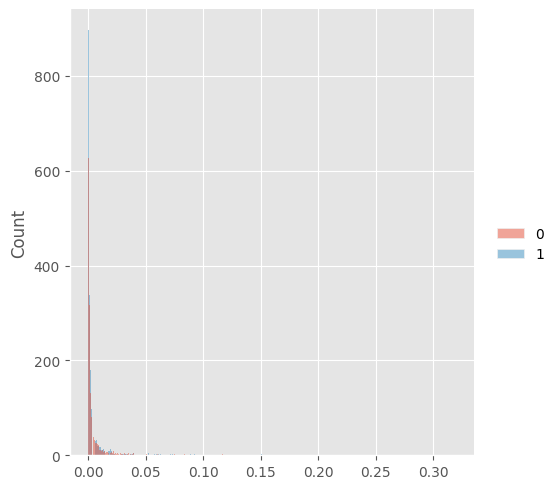

In [24]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [25]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7716666666666666


# **Questions**

1. In the "Bayes on Text - Classifying papers at Arxiv" section, what preprocessing steps are performed on the Arxiv paper data? Why are these steps necessary?

2. How are probability distributions learned from the Arxiv paper data, and how are these distributions used in the classification of papers into Computer Science (CS) and Statistics (Stat) categories?

3. What is probability smoothing, and why is it necessary in the context of the Bayesian classifier used in this code? How does Laplace smoothing improve the model's performance, and what parameter is involved in Laplace smoothing?

4. The code uses Laplace smoothing with a fixed value of alpha = 0.1. How might you experiment with different values of alpha to observe the impact on classification accuracy? Provide an example of how you would modify the code to test various alpha values.

5. In the "Visualizing the Decision Surface" section, the code visualizes the decision boundary for the Gaussian Naive Bayes classifier. How would you adjust the code to change the size or color of the decision boundary line, and what significance might these changes have?

# Answers:

Answer1:

The steps involved are:

* Data Cleaning and Preprocessing:
1. Loading the JSON Data
2. leaning the "tag" Column:

  The "tag" column contains JSON-like strings that need to be parsed. The code applies a lambda function to each element in the "tag" column

3. Grouping Categories:

  * The code further processes the "tag" column to group related categories. It replaces specific categories such as 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', and 'nucl-th' with 'physics' for simplification and categorization.
  * This simplification helps in reducing the number of classes and makes the classification task more manageable.

4. Removing Unnecessary Columns

5. Sample Selection:

  * The code samples papers from two main categories, 'cs' and 'stat', using the specified sample sizes. This step selects a subset of papers from these categories for building the classification model.

6. Text Preprocessing:

  * The code further processes the data by tokenizing and cleaning the text data from the "summary" and "title" columns. It tokenizes the text into words, converts them to lowercase, and applies filtering based on specified thresholds for word count and word length.
  * Words that have a length less than WORD_LENGTH_THRESHOLD and contain digits or parentheses are removed. Additionally, words with a count less than WORD_COUNT_THRESHOLD are filtered out.

7. Data Splitting

Answer 2:


In the context of classifying Arxiv papers into "cs" or "stat" categories:

1. Conditional probabilities are learned for each word, indicating how likely a word appears in a "cs" paper or a "stat" paper using Bayes' rule.

2. Prior probabilities are computed based on the training data, giving the initial likelihood of a paper belonging to either category.

3. Evidence probabilities are determined for both categories, taking into account the frequency of words in each category's papers. These probabilities contribute to the overall classification process.

Answer 3:

Probability smoothing is a technique used to address the issue of zero probabilities in Bayesian classifiers. In the context of the Bayesian classifier used in the code, Laplace smoothing (or add-one smoothing) is applied to avoid zero probabilities for words not seen in one category. Laplace smoothing improves model performance by preventing extreme probability estimates. The parameter involved in Laplace smoothing is typically denoted as "k," representing the number added to the count of each word to avoid zero probabilities.

Answeer 4:

Alpha = 0.0001: Accuracy = 0.8108333333333333
Alpha = 0.01: Accuracy = 0.8025
Alpha = 1.0: Accuracy = 0.6591666666666667


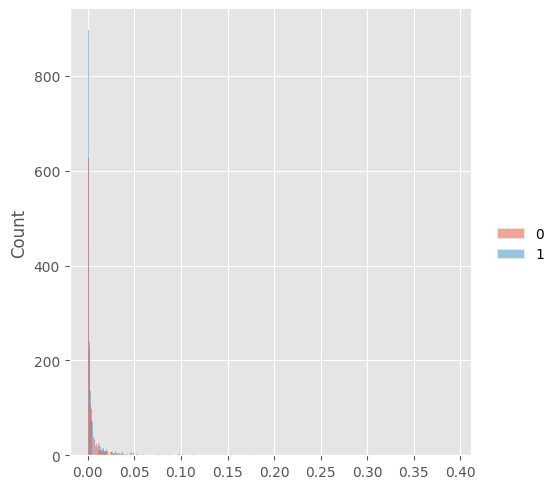

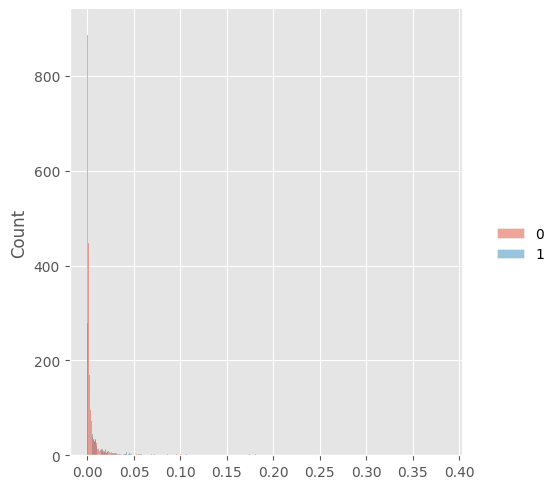

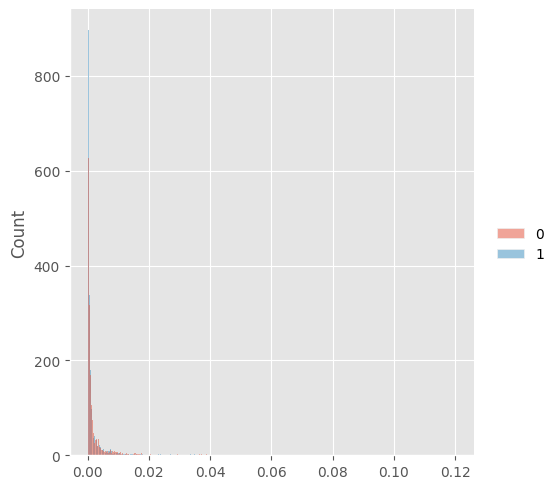

In [28]:
alphas = [0.0001, 0.01, 1.0]

for alpha in alphas:
  counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
  evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                              (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
  #print(np.min(evidence_smooth))
  sns.displot(evidence_smooth)


alphas = [0.0001, 0.01, 1.0]

accuracy_results = {}

for alpha in alphas:
    counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
    evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                                (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T

    correct, total = 0, 0
    answers = []

    for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
        this_counts = np.zeros(len(words))
        for word in keywords:
            idx = words_to_index[word]
            if idx != -1:
                this_counts[idx] = 1

        marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
        joint = np.sum(np.log(marginal), axis=0)
        predicted = 'cs' if joint[0] > joint[1] else 'stat'
        answers.append(predicted)

        if predicted == tag:
            correct += 1
        total += 1

    accuracy = correct / total

    accuracy_results[alpha] = accuracy

    print(f"Alpha = {alpha}: Accuracy = {accuracy}")

Answer 5:

In [ ]:
ax.vlines(0.5, 0, 1750, color="hotpink", linestyles="--", lw=2a)

In [ ]:
ax.vlines(0.7, 0, 1750, color="blue", linestyles="--", lw=1)

* 'color' : Changes the color
* 'line width : Adjust width of the line.